# Inspection of DC2 Run 2.2i DR6 Object Table 
### Michael Wood-Vasey (@wmwv)
### Last Verified to Run: 2020-06-04 by MWV

Inspect the Run 2.2i DR6 Object Table

This notebook is more qualitative rather than quantitative validation.  The analysis contained here should eventually grow beyond the confines of a notebook to include goals for the visualizations and numerical thresholds for specific quantities.

1. Make 2D density plots (e.g., `hexbin`, `hist2d`, `datashader`) of
    - ra, dec
    - u-g, g-r
    - r-i, g-r
    - i-z, g-r
    - z-y, g-r
2. Make 1D density plots (e.g., `hist`, kernel-density-estimation)
    - N({ugrizy})
    - Shape parameters

#### Run 2.2i DR6 as of 2020-06-04 includes  
  * 78 tracts
  * 52 million objects  
  * 34 million objects with i-band SNR > 5

Loading two columns of entire catalog from parquet file takes a few minutes, depending on memory load on the JupyterHub node.  It thus is often most useful to develop ones codes looking at only subsamples of the full DC2 datasets, whether that's considering just one tract, or taking a subsample of the full catalog.

#### Quick Data Size estimates

Loading 1 column stored as 64-bit floats on 64 million objects takes 512 MB of memory:

8 bytes/column/row * 1 column * 64 million rows = 2^3 * 2^0 * 2^6 million bytes (MB) = 2^9 MB = 512 MB

We're using the DPDD Parquet file directly:
/global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/dpdd/dc2_object_run2.2i_dr6.parquet

It's 42 GB.  Needs to be used in significantly-restricted column mode or with some Spark/DASK approach.

## Import Needed Modules

In [1]:
import math
import os

import numpy as np
from numpy.lib import scimath as SM

import astropy.units as u
import pandas as pd

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import seaborn as sns

In [3]:
cmap = 'viridis'

## Define Catalog and Subsampling

In [4]:
catalog_dirname = "/global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/dpdd/"
catalog_basename = "dc2_object_run2.2i_dr6.parquet"
catalog_file = os.path.join(catalog_dirname, catalog_basename)

In [5]:
sampling_factor = 1

## Load Data

In [6]:
filters = ('u', 'g', 'r', 'i', 'z', 'y')

In [7]:
columns = ['ra', 'dec']
columns += [f'mag_{f}' for f in filters]
columns += [f'magerr_{f}' for f in filters]
columns += [f'mag_{f}_cModel' for f in filters]
columns += [f'magerr_{f}_cModel' for f in filters]
columns += [f'Ixx_{f}' for f in filters]
columns += [f'Ixy_{f}' for f in filters]
columns += [f'Iyy_{f}' for f in filters]
columns += [f'psf_fwhm_{f}' for f in filters]
columns += ['good', 'extendedness', 'blendedness']

In [8]:
N = 52000000
MB_per_column = 512 * (N / 64000000) # MB / column / 64 million rows
print(f'We are going to load {len(columns)} columns.')
print(f'For {N//sampling_factor} million rows that should take {(len(columns)/sampling_factor)*MB_per_column/1024:0.2f} GB of memory')

We are going to load 53 columns.
For 52000000 million rows that should take 21.53 GB of memory


In [9]:
df = pd.read_parquet(catalog_file, columns=columns)

In [12]:
print(f'Loaded {len(df)} objects.')

Loaded 51802478 objects.
Loaded 34477764 good objects.


### Define Ellipticity

In [16]:
def ellipticity(I_xx, I_xy, I_yy):
    """Calculate ellipticity from second moments.

    Parameters
    ----------
    I_xx : float or numpy.array
    I_xy : float or numpy.array
    I_yy : float or numpy.array

    Returns
    -------
    e, e1, e2 : (float, float, float) or (numpy.array, numpy.array, numpy.array)
        Complex ellipticity, real component, imaginary component
        
    Copied from https://github.com/lsst/validate_drp/python/lsst/validate/drp/util.py
    """
    e = (I_xx - I_yy + 2j*I_xy) / (I_xx + I_yy + 2*SM.sqrt(I_xx*I_yy - I_xy*2))
    e1 = np.real(e)
    e2 = np.imag(e)
    return e, e1, e2

In [17]:
for filt in filters:
    df[f'e_{filt}'], df[f'e1_{filt}'], df[f'e2_{filt}'] = \
    ellipticity(df[f'Ixx_{filt}'], df[f'Ixy_{filt}'], df[f'Iyy_{filt}'])

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/numpy/lib/scimath.py:122: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):


In [10]:
# Select good detections:
#  1. Marked as 'good' in catalog flags.
#  2. SNR in given band > threshold
#  3. In defined simulation range
snr_threshold = 5
snr_filter = 'i'

# We want to do a SNR cut, but magerr is the thing already calculated
# So we'll redefine our SNR in terms of magerr
magerr_cut = (2.5 / np.log(10)) / snr_threshold
magerr_col = f'magerr_{snr_filter}'

In [36]:
good_idx = df["good"] & (df[magerr_col] < magerr_cut)
good = df.loc[good_idx]

In [12]:
print(f'Loaded {len(good)} good objects.')

Loaded 51802478 objects.
Loaded 34477764 good objects.


## Object Density in RA, Dec

DC2 Run 2.x WFD and DDF regions
https://docs.google.com/document/d/18nNVImxGioQ3tcLFMRr67G_jpOzCIOdar9bjqChueQg/view
https://github.com/LSSTDESC/DC2_visitList/blob/master/DC2visitGen/notebooks/DC2_Run2_regionCoords_WFD.ipynb

| Location          | RA (degrees) | Dec (degrees) | RA (degrees) | Dec (degrees) |
|:----------------- |:------------ |:------------- |:------------ |:------------- |
| Region            | WFD          | WFD           | DDF          | DDF           |
| Center            | 61.856114    | -35.79        | 53.125       | -28.100       |
| North-East Corner | 71.462228    | -27.25        | 53.764       | -27.533       |
| North-West Corner | 52.250000    | -27.25        | 52.486       | -27.533       |
| South-West Corner | 49.917517    | -44.33        | 52.479       | -28.667       |
| South-East Corner | 73.794710    | -44.33        | 53.771       | -28.667       |

(Note that the order of the rows above is different than in the DC2 papers.  The order of the rows above goes around the perimeter in order.)

In [13]:
dc2_run2x_wfd = [[71.462228, -27.25], [52.250000, -27.25], [49.917517, -44.33], [73.794710, -44.33]]
dc2_run2x_ddf = [[53.764, -27.533], [52.486, -27.533], [52.479, -28.667], [53.771, -28.667]]

In [14]:
def plot_ra_dec(cat, show_dc2_region=True, bins=100, cmin=100):
    """We're just doing this on a rectilinear grid.
    We should do a projection, of course, but that distortion is tolerable in this space."""
    fig = plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_aspect(1)

    plt.hist2d(cat['ra'], cat['dec'], bins=bins, cmin=cmin)
    ax.invert_xaxis()  # Flip to East left
    plt.xlabel('RA [deg]')
    plt.ylabel('Dec [deg]')
    plt.colorbar(shrink=0.5, label='objects / bin')

    if show_dc2_region:
        # This region isn't quite a polygon.  The sides should be curved.
        wfd_region = Polygon(dc2_run2x_wfd, color='red', fill=False)
        ddf_region = Polygon(dc2_run2x_ddf, color='orange', fill=False)
        ax.add_patch(wfd_region)
        ax.add_patch(ddf_region)

        max_delta_ra = dc2_run2x_wfd[3][0] - dc2_run2x_wfd[2][0]
        delta_dec = dc2_run2x_wfd[1][1] - dc2_run2x_wfd[3][1]
        grow_buffer = 0.05
        ax.set_xlim(dc2_run2x_wfd[3][0] + max_delta_ra * grow_buffer,
                    dc2_run2x_wfd[2][0] - max_delta_ra * grow_buffer)
        ax.set_ylim(dc2_run2x_wfd[3][1] - delta_dec * grow_buffer,
                    dc2_run2x_wfd[1][1] + delta_dec * grow_buffer)

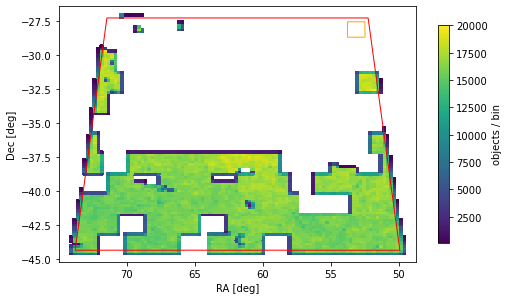

In [15]:
plot_ra_dec(df)

The overall object density distribution looks good.  The purple edges are regions where the histgoram bin partially overlaps a tract edge.  Withouth perfect alignment, one should always expect some partial overlap, but that overlap amount will change.  So the overlap at the top of a row of tracts remains constant, but the edge overlap between the RA bounds of each tract will be different, so some are purple, some are blue, and some are green above.

Notes:
* We're missing the DDF region, which was specifically not included in this processing
* There are also a few patches that failed within the main region.
* There is an overall gradient N/S in object density, because we're plotting in rectilinear RA, Dec bins, which means that bins at the bottom in RA cover less area than those at the top.

See the input visit coverage map here:
https://github.com/LSSTDESC/ImageProcessingPipelines/issues/97#issuecomment-498303504


In [18]:
stars = df.loc[df['extendedness'] == 0]
galaxies = df.loc[df['extendedness'] > 0]

In [19]:
print(f'Total: {len(df)}, Good: {len(good)}, Stars: {len(stars)}, Galaxies: {len(galaxies)}')
print(f'For {catalog_file} with {sampling_factor}x subsample')

Total: 51802478, Good: 34477764, Stars: 11677827, Galaxies: 39602485
For /global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/dpdd/dc2_object_run2.2i_dr6.parquet with 1x subsample


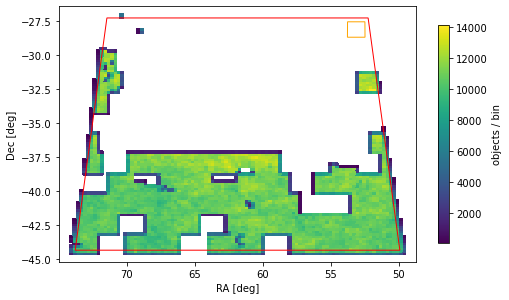

In [20]:
plot_ra_dec(good)

## Color-Color Diagrams and the Stellar Locus

In [21]:
# We refer to a file over in `tutorials/assets' for the stellar locus
datafile_davenport = '../tutorials/assets/Davenport_2014_MNRAS_440_3430_table1.txt'

def get_stellar_locus_davenport(color1='gmr', color2='rmi',
                                datafile=datafile_davenport):
    data = pd.read_table(datafile, sep='\s+', header=1)
    return data[color1], data[color2]

    
def plot_stellar_locus(color1='gmr', color2='rmi',
                       color='blue', linestyle='--', linewidth=2.5,
                       ax=None):
    model_gmr, model_rmi = get_stellar_locus_davenport(color1, color2)
    plot_kwargs = {'linestyle': linestyle, 'linewidth': linewidth, 'color': color,
                   'scalex': False, 'scaley': False}
    if not ax:
        ax = fig.gca()

    ax.plot(model_gmr, model_rmi, **plot_kwargs)

In [22]:
def plot_color_color(z, color1, color2, 
                     range1=(-1, +2), range2=(-1, +2), bins=101,
                     cmin=10, cmap='gist_heat_r',
                     vmin=None, vmax=None,
                     ax=None, figsize=(4,4)):
    """Plot a color-color diagram.  Overlay stellar locus"""
    band1, band2 = color1[0], color1[-1]
    band3, band4 = color2[0], color2[-1]
    H, xedges, yedges = np.histogram2d(
        z[f'mag_{band1}'] - z[f'mag_{band2}'],
        z[f'mag_{band3}'] - z[f'mag_{band4}'],
        range=(range1, range2), bins=bins)
        
    zi = H.T
    xi = (xedges[1:] + xedges[:-1])/2
    yi = (yedges[1:] + yedges[:-1])/2

    if not ax:
        fig = plt.figure(figsize=figsize)
        ax = fig.gca()

    # Only take elements with a minimum number of entries
    zi = np.where(zi >= cmin, zi, np.nan)

    im = ax.pcolormesh(xi, yi, zi, cmap=cmap, vmin=vmin, vmax=vmax)
    cf = ax.contour(xi, yi, zi)
    ax.set_xlabel(f'{band1}-{band2}')
    ax.set_ylabel(f'{band3}-{band4}')

    try:
        plot_stellar_locus(color1, color2, ax=ax)
    except KeyError as e:
        print(f"Couldn't plot Stellar Locus model for {color1}, {color2}")
        
    return im

In [23]:
def plot_four_color_color(cat, vmin=0, vmax=50000):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    colors = ['umg', 'rmi', 'imz', 'zmy']
    ref_color = 'gmr'
    for ax, color in zip(axes.flat, colors):
        try:
            im = plot_color_color(cat, ref_color, color, ax=ax,
                                 vmin=vmin, vmax=vmax)
            ax.set_ylim(-1, +2)
        except KeyError:
            continue
            
    fig.colorbar(im)
    plt.tight_layout()



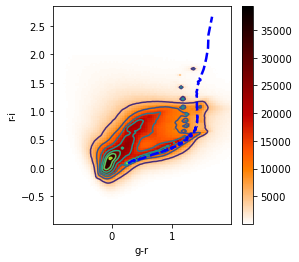

In [24]:
im = plot_color_color(good, 'gmr', 'rmi')
plt.colorbar(im)

Couldn't plot Stellar Locus model for gmr, zmy


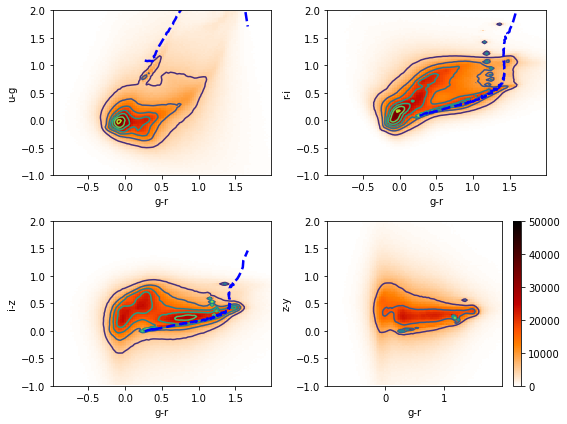

In [25]:
plot_four_color_color(good, vmax=50000)

Couldn't plot Stellar Locus model for gmr, zmy


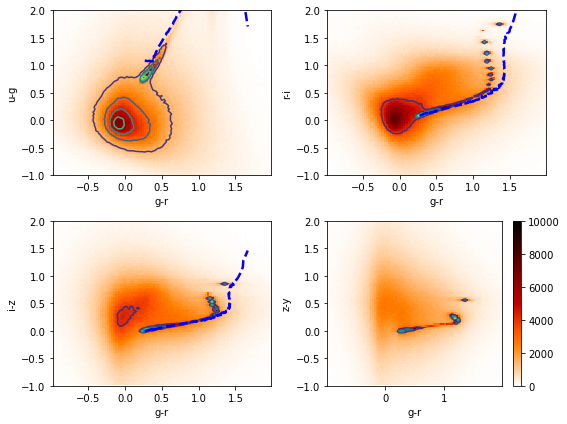

In [26]:
plot_four_color_color(stars, vmax=10000)

The discrete islands in the data for stellar color-color plot -- most visible in `r-i` vs. `g-r` at g-r ~= 1.2 mag -- are due to the finite set of stellar models used for simulating M dwarfs.

------
Let's plot the galaxies on the same color-color plots

Clearly one doesn't expect the galaxies to follow the stellar locus.  But including the stellar locus lines makes it easy to guide the eye between the stars-only and the galaxies-only plots.  

Couldn't plot Stellar Locus model for gmr, zmy


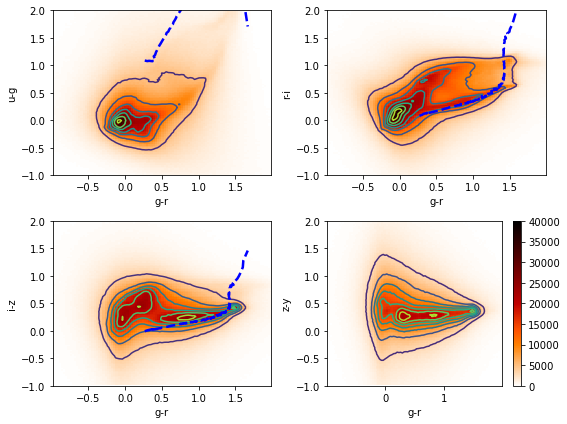

In [27]:
plot_four_color_color(galaxies, vmax=40000)

Questions for further study:
   1. Is there a better comparison sample for the stellar locus than the Davenport reference?
   2. Why is the stellar locus in the Davenport 0.1--0.2 mag redder for the reddest stars than the observed data.  Are there different extinction assumptions (this should be a low-extinction region).  Are there different bandpasses used?

## 1D Density Plots

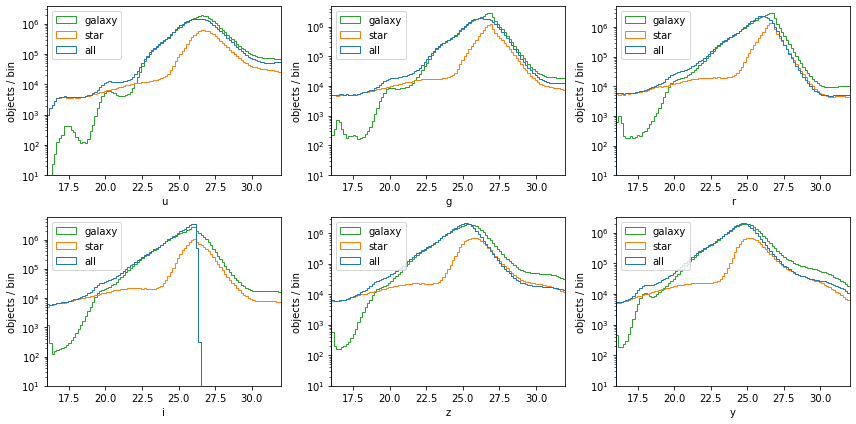

In [28]:
def plot_mag(filt, log=True, range=(16, 28), ax=None, ):
    if ax is None:
        ax = fig.gca()
    mag = f'mag_{filt}'
    ax.hist([good[mag], stars[mag], galaxies[mag]],
            label=['all', 'star', 'galaxy'],
            log=log,
            range=range,
            bins=np.linspace(*range, 100),
            histtype='step')
    ax.set_xlabel(filt)
    ax.set_ylabel('objects / bin')
    ax.set_xlim(range)
    ax.set_ylim(bottom=10)
    ax.legend(loc='upper left')

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for ax, filt in zip(axes.flat, filters):
    plot_mag(filt, ax=ax, range=(16, 32))
    
plt.tight_layout()

The sharp cut in i-band is because that was the reference band for most detections.  The distributions in the other bands extend to 28th mag because many of the forced-photometry measurements are consistent with 0.

To compare number densities, we have to calculate the area covered by each catalog.
We'll use Healpix through HealPy to pixelate the region and then count of the number of pixels with significant numbers of objects.

In [29]:
def calculate_area(cat, threshold=0.25, nside=1024, verbose=False):
    """Calculate the area covered by a catalog with 'ra', 'dec'
    
    Parameters:
    --
    cat: DataFrame, dict-like with 'ra', 'dec', keys
    threshold:  float
        Fraction of median value required to count a pixel.
    nside:  int
        Healpix NSIDE.  NSIDE=1024 is ~12 sq arcmin/pixel, NSIDE=4096 is 0.74 sq. arcmin/pixel
        Increasing nside will decrease calculated area as holes become better resolved 
        and relative Poisson fluctuations in number counts become more significant.
    verbose:  bool
        Print details on nside, number of significant pixels, and area/pixel.
        
    Returns:
    --
    area:  Astropy Quantity.
    """
    import healpy as hp

    indices = hp.ang2pix(nside, cat['ra'], cat['dec'], lonlat=True)
    idx, counts = np.unique(indices, return_counts=True)
    
    # Take the 25% of the median value of the non-zero counts/pixel
    threshold_counts = threshold * np.median(counts)

    if verbose:
        print(f'Median {np.median(counts)} objects/pixel')
        print(f'Only count pixels with more than {threshold_counts} objects')

    significant_pixels, = np.where(counts > threshold_counts)
    area_pixel = hp.nside2pixarea(nside, degrees=True) * u.deg**2

    if verbose:
        print(f'Pixel size ~ {hp.nside2resol(nside, arcmin=True) * u.arcmin:0.2g}')
        print(f'nside: {nside}, area/pixel: {area_pixel:0.4g}, num significant pixels: {len(significant_pixels)}')

    area = len(significant_pixels) * area_pixel

    if verbose:
        print(f'Total area: {area:0.7g}')
    
    return area

In [30]:
area_dc2 = calculate_area(galaxies)
print(f'DC2 Run 2.2i area: {area_dc2:0.2f}')

DC2 Run 2.2i area: 108.66 deg2


In [31]:
num_den_dc2 = sampling_factor * len(galaxies) / area_dc2

# Change default expression to 1/arcmin**2
num_den_dc2 = num_den_dc2.to(1/u.arcmin**2)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


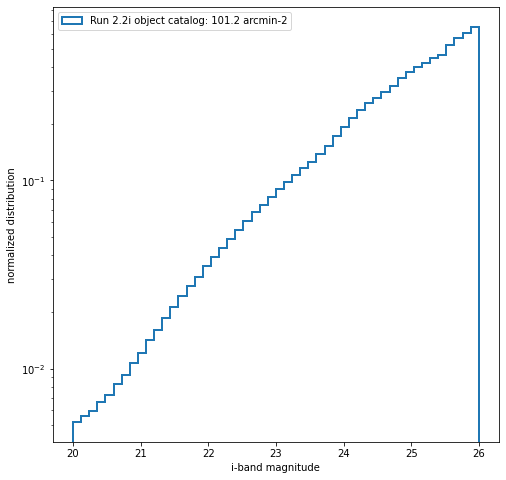

In [32]:
# Now we plot the *normalized* i-band magnitude distributions in Run 2.2i and HSC.
# They are normalized so we can focus on the shape of the distribution.
# However, the legend indicates the total number density of galaxies selected with our magnitude cut,
# which lets us find issues with the overall number density matching (or not).

max_mag_i = 26
plt.figure(figsize=(8, 8))
nbins = 50
mag_range = [20, max_mag_i]
data_to_plot = [galaxies['mag_i']]
labels_to_plot = [
    f'Run 2.2i object catalog: {num_den_dc2.value:.1f} {num_den_dc2.unit:fits}',
]
plt.hist(data_to_plot, nbins, range=mag_range, histtype='step',
         label=labels_to_plot, linewidth=2.0, density=True)
    
plt.legend(loc='upper left')
plt.xlabel('i-band magnitude')
plt.ylabel('normalized distribution')
plt.yscale('log')
plt.savefig('dc2_object_run2.2i_galaxy_counts.pdf')

## Magnitude Error vs. Magnitude

The magnitude uncertainties come directly from the poisson estimates of the flux measurements.  By construction they will follow smooth curves.  We here confirm that they do.

In [38]:
def plot_mag_magerr(df, band, ax=ax, range=(16, 28), magerr_limit=0.25, vmin=100):
    # Restrict to reasonable range
    mag_col, magerr_col = f'mag_{band}', f'magerr_{band}'
    good = df[df[magerr_col] < magerr_limit]

    ax.hexbin(good[mag_col], good[magerr_col], vmin=vmin)
    ax.set_xlabel(band)
    ax.set_ylabel(f'{band} err');
    ax.set_ylim(0, magerr_limit)

In [39]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']

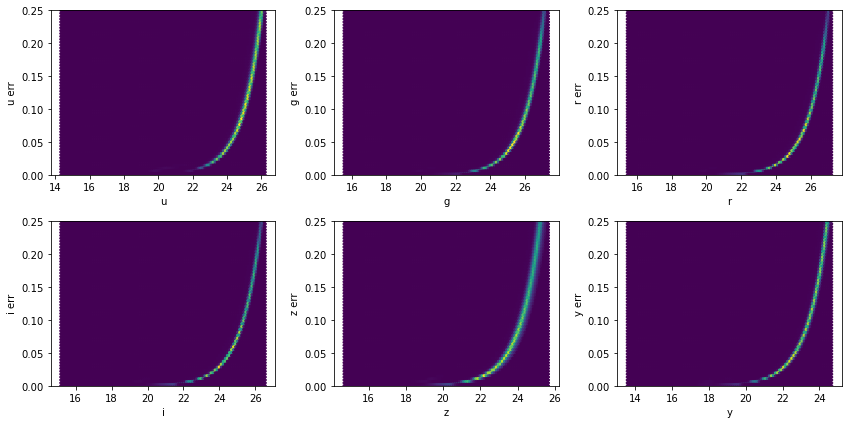

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for ax, filt in zip(axes.flat, filters):
    plot_mag_magerr(galaxies, filt, ax=ax)
plt.tight_layout()

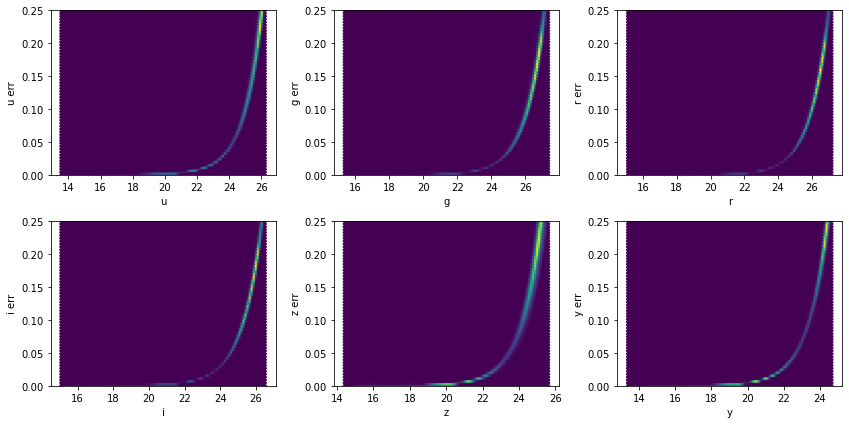

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for ax, filt in zip(axes.flat, filters):
    plot_mag_magerr(stars, filt, ax=ax)
plt.tight_layout()

## Blendedness

Blendedness is a measure of how much the identified flux from an object is affected by overlapping from other objects.

See Bosch et al., 2018, Section 4.9.11.

In [42]:
w, = np.where(np.isfinite(good['blendedness']))

In [43]:
print(f'{100 * len(w)/len(good):0.1f}% of objects have finite blendedness measurements.')

97.0% of objects have finite blendedness measurements.


Question for futher study:  What happened to yield non-finite blendedness measurements?

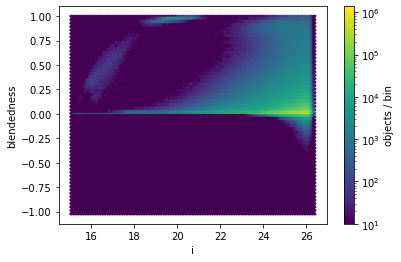

In [44]:
good_blendedness = good.loc[np.isfinite(good['blendedness'])]
plt.hexbin(good_blendedness['mag_i'], good_blendedness['blendedness'],
          bins='log', vmin=10);
plt.xlabel('i')
plt.ylabel('blendedness');
plt.colorbar(label='objects / bin');

### Extendedness
 
Extendedness is essentially star/galaxy separation based purely on morphology in the main detected reference band (which is `i` for most Objects).

Extendedness a binary property in the catalog, so it's either 0 or 1.

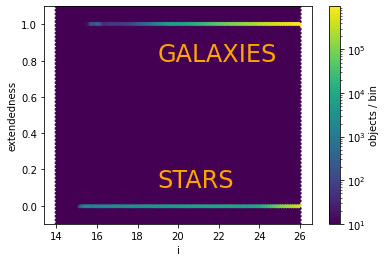

In [45]:
plt.hexbin(good['mag_i'], good['extendedness'],
           extent=(14, 26, -0.1, +1.1),
           bins='log', vmin=10);
plt.xlabel('i')
plt.ylabel('extendedness');
plt.ylim(-0.1, 1.1)
plt.text(19, 0.1, "STARS", fontdict={'fontsize': 24}, color='orange')
plt.text(19, 0.8, "GALAXIES", fontdict={'fontsize': 24}, color='orange')
plt.colorbar(label='objects / bin');

While the first plot above made extendedness look like a simple binary property, the truth is more complicated.

As galaxies get smaller in angular size and lower in signal-to-noise ratio, it becomes harder to clearly distinguish stars from galaxies.

Extendedness is based off of the difference between the point-source model and extended model brightness.  Specifically objects with `mag_psf - mag_cmodel > 0.164` mag are labeled with `extendedness=1` (i.e., galaxies).

See Bosch et al. 2018, Section 4.9.10 for details.

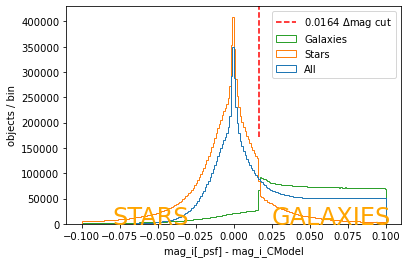

In [46]:
plt.axvline(0.0164, 0.4, 1, color='red', linestyle='--',
           label=r'0.0164 $\Delta$mag cut')  # psf-cModel mag cut from Bosch et al. 2018.

plt.hist([good['mag_i'] - good['mag_i_cModel'],
         stars['mag_i'] - stars['mag_i_cModel'],
         galaxies['mag_i'] - galaxies['mag_i_cModel']],
         label=['All', 'Stars', 'Galaxies'],
         bins=np.linspace(-0.1, 0.1, 201),
         histtype='step')

plt.legend()
plt.xlabel('mag_i[_psf] - mag_i_CModel');
plt.ylabel('objects / bin')

plt.text(-0.080, 100, "STARS", fontdict={'fontsize': 24}, color='orange')
plt.text(+0.025, 100, "GALAXIES", fontdict={'fontsize': 24}, color='orange');

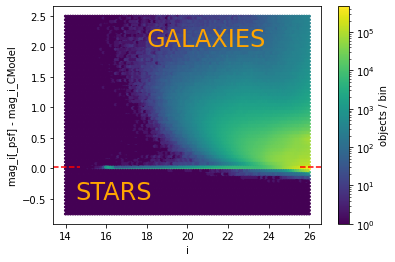

In [47]:
plt.hexbin(good['mag_i'], good['mag_i']-good['mag_i_cModel'],
           extent=(14, 26, -0.75, +2.5),
           bins='log');
plt.xlabel('i')
plt.ylabel('mag_i[_psf] - mag_i_CModel');
plt.text(14.5, -0.5, "STARS", fontdict={'fontsize': 24}, color='orange')
plt.text(18, 2, "GALAXIES", fontdict={'fontsize': 24}, color='orange')
plt.colorbar(label='objects / bin');

plt.axhline(0.0164, 0.92, 1.0, color='red', linestyle='--')
plt.axhline(0.0164, 0, 0.1, color='red', linestyle='--',
            label=r'0.0164 $\Delta$mag cut');  # psf-cModel mag cut from Bosch et al. 2018.

We can zoom in a little to see how the fixed 0.0164 mag cut works at the low SNR limit.  Specifically at mag 24, we're starting to run out of stars and most things are galaxies.  But that's a population prior, it's not something visible using just morphology information.

You can see the effect of lower SNR measurements as the horizontal line at $\Delta$mag=0 puff up due to increased uncertainties.

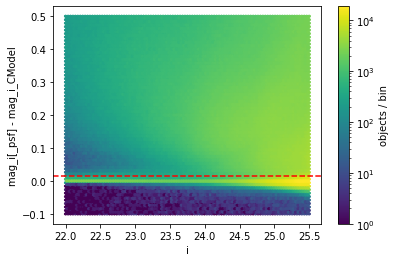

In [48]:
plt.hexbin(good['mag_i'], good['mag_i']-good['mag_i_cModel'],
           extent=(22, 25.5, -0.1, +0.5),
           bins='log');
plt.xlabel('i')
plt.ylabel('mag_i[_psf] - mag_i_CModel');
plt.colorbar(label='objects / bin');

plt.axhline(0.0164, 0, 1, color='red', linestyle='--',
            label=r'0.0164 $\Delta$mag cut');  # psf-cModel mag cut from Bosch et al. 2018.

If we add in color information, 

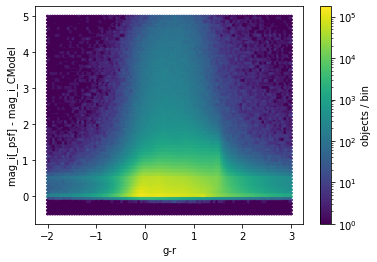

In [49]:
plt.hexbin(good['mag_g'] - good['mag_r'], good['mag_i']-good['mag_i_cModel'],
           extent=(-2, +3, -0.5, +5),
           bins='log');
plt.xlabel('g-r')
plt.ylabel('mag_i[_psf] - mag_i_CModel');
# plt.text(14.5, 0.3, "STARS", fontdict={'fontsize': 24}, color='orange')
# plt.text(18, 2, "GALAXIES", fontdict={'fontsize': 24}, color='orange')
plt.colorbar(label='objects / bin');

Text(0, 0.5, 'objects / bin')

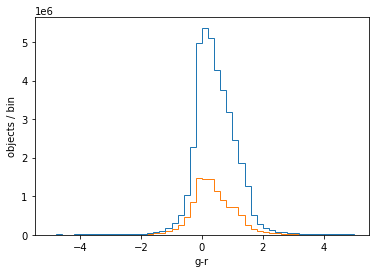

In [50]:
plt.hist([galaxies['mag_g'] - galaxies['mag_r'], stars['mag_g'] - stars['mag_r']],
        label=['galaxies', 'stars'], histtype='step',
        bins=np.linspace(-5, +5, 51));
plt.xlabel('g-r')
plt.ylabel('objects / bin')

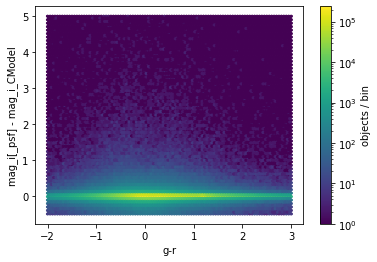

In [51]:
plt.hexbin(stars['mag_g'] - stars['mag_r'], stars['mag_i'] - stars['mag_i_cModel'],
           extent=(-2, +3, -0.5, +5),
           bins='log');
plt.xlabel('g-r')
plt.ylabel('mag_i[_psf] - mag_i_CModel');
# plt.text(14.5, 0.3, "STARS", fontdict={'fontsize': 24}, color='orange')
# plt.text(18, 2, "GALAXIES", fontdict={'fontsize': 24}, color='orange')
plt.colorbar(label='objects / bin');

## Shape Parameters

Ixx, Iyy, Ixy

In [52]:
def plot_shape(filt, ax=None, legend=True):
    if not ax:
        ax = fig.gca()

    names = ['all', 'star', 'galaxy']
    colors = ['blue', 'orange', 'green']
    hist_kwargs = {'color': colors, 'log': True,
             'bins': np.logspace(-1, 1.5, 100),
             'range': (0, 50),
             'histtype': 'step'}
    for prefix, ls in (('Ixx', '-'), ('Iyy', '--'), ('Ixy', ':')):
        field = f'{prefix}_{filt}'
        labels = [f'{prefix} {name}' for name in names]
        ax.hist([good[field], stars[field], galaxies[field]],
                label=labels,
                linestyle=ls,
                **hist_kwargs)

    ax.set_ylim(100, ax.get_ylim()[1])
    
    ax.set_xlabel(f'{filt}-band Moments: Ixx, Iyy, Ixy [pixels^2]')
    ax.set_ylabel('objects / bin')
    if legend:
        ax.legend()

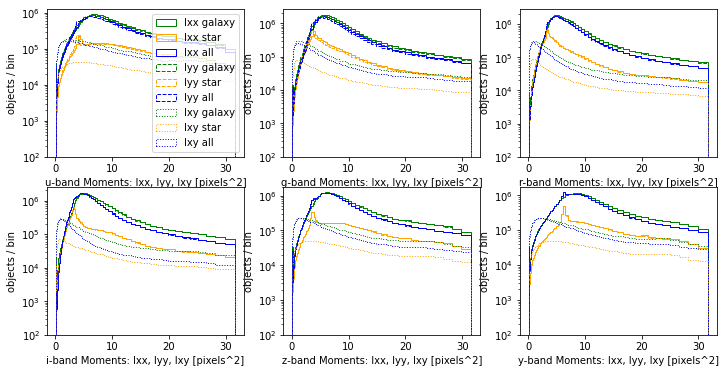

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
legend = True
for ax, filt in zip(axes.flat, filters):
    plot_shape(filt, ax=ax, legend=legend)
    legend = False

The stars (orange) are concentrated at low values of the source moments.

Would be interesting to
1. Look by magnitude or SNR to undersatnd the longer tail.  Are these galaxies mis-classified as stars, or are these noise sources?
2. Distribution of ellipticity (see validate_drp to type this right)

In [54]:
def plot_ellipticity(good, stars, galaxies, filt, ax=None, legend=True):
    if not ax:
        ax = fig.gca()

    names = ['all', 'star', 'galaxy']
    colors = ['blue', 'orange', 'green']
    hist_kwargs = {'color': colors, 'log': True,
             'bins': np.logspace(-1, 1.5, 100),
             'range': (0, 5),
             'histtype': 'step'}
    for prefix, ls in (('e', '-'), ('e1', '--'), ('e2', ':')):
        field = f'{prefix}_{filt}'
        labels = [f'{prefix} {name}' for name in names]
        ax.hist([good[field], stars[field], galaxies[field]],
                label=labels,
                linestyle=ls,
                **hist_kwargs)

    ax.set_xlim(0, 20)
    ax.set_ylim(10, ax.get_ylim()[1])
    
    ax.set_xlabel(f'{filt}-band ellipticity')
    ax.set_ylabel('objects / bin')
    if legend:
        ax.legend()

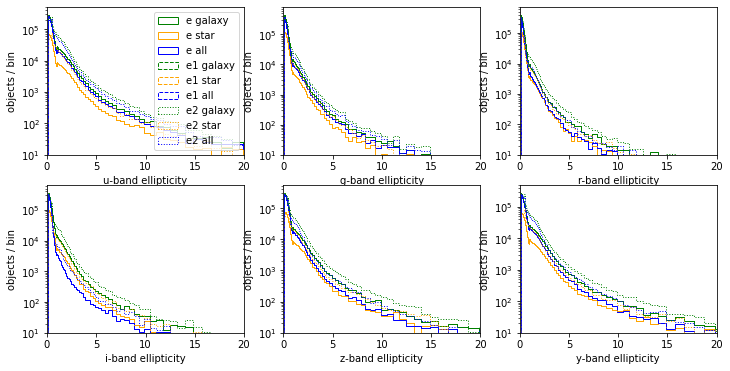

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
legend = True
for ax, filt in zip(axes.flat, filters):
    plot_ellipticity(good, stars, galaxies, filt, ax=ax, legend=legend)
    legend = False

### FWHM of the PSF
At the location of the catalog objects.

The Object Table stores the shape parameters of the PSF model as evaluated at the location of the object.

This is not the same as, but is certainly related to, the distribution of effective seeing in the individual images that made up the coadd.

In [56]:
def plot_psf_fwhm(filters=filters,
                 colors=('purple', 'blue', 'green', 'orange', 'red', 'brown')):
    for filt, color in zip(filters, colors):
        psf_fwhm = np.array(good[f'psf_fwhm_{filt}'])
        w, = np.where(np.isfinite(psf_fwhm) & (psf_fwhm < 3))
        sns.distplot(psf_fwhm[w], label=filt, color=color)
    plt.xlabel('PSF FWHM [arcsec]')
    plt.ylabel('normalized object density')
    plt.legend()

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__m

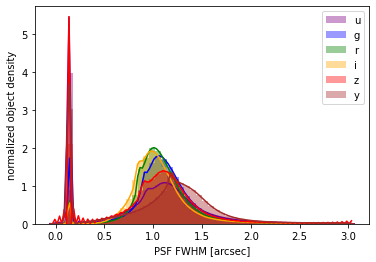

In [57]:
plot_psf_fwhm()

**Note the significant excees at unphysical values of FWHM.**

Should check to see what's going on.  These should be the PSF model at the location of the object, so this is quite odd.

We do see here that the model PSF FWHM from the coadd achieves the best seeing in r and i.  Providing the best seeing in r and i is one of the goals of the observation planning, so this part looks successful.

Questions for further investigation:
1. How do the above distributions of PSF FWHM compare to the effective per-visit seeing?
2. How do the above distributions of PSF FWHM compare to the OpSim simulation, minion_1016, used to generated DC2 Run 2.1i?
3. Are the model PSFs from the coadd reasonable?  The coadds are generated by combining the individual images -- that may not result in PSFs that coherently make sense across a given region of the coadd, particularly as more and more objects are intersected by CCD boundaries and gaps.